In [1]:
# Import standard library modules
import sys

# Set the relative path to the project root directory
relative_path_to_root = "../../../"

# Add the project root to the system path for importing in-house modules
sys.path.append(relative_path_to_root)

# Import in-house modules from the 'utilities' package
from utilities import clean_historical_data, check_tickers_for_missing_values
from utilities import calc_vif, calc_p_values, calc_correlation, highlight_vif, highlight_p_values, evaluate_regression_model, evaluate_cross_validation, evaluate_classifier_model
from utilities import load_data, save_data

In [2]:
# Data manipulation and analysis
import pandas as pd

# Date and time manipulation
from datetime import date

# File and directory manipulation
from pathlib import Path

# Data preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
file_name = "sp500_updated_adj_close_with_nas"
file_path = f"../../../data/raw_data/{file_name}"

raw_data = load_data(file_path)

╔═══════════════════════════════════════════════════════════════╗
║File `updated_w_nas.csv.bz2` loaded from `sp500_updated_adj_close_with_nas.zip`║
╚═══════════════════════════════════════════════════════════════╝


#### Inspect Tickers Individually

In [4]:
# Inspect Cleaned data zeroing in on individual tickers
select_df = raw_data.copy()

select_ticker = select_df["Ticker"] == "AAPL"

select_df[select_ticker].tail(3)

,Date,Ticker,Adjusted Close,Today to Tomorrow,Yesterday to Today,Next Day Close,Previous Day Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
2119732,2024-10-23,AAPL,230.76,-1.0,-1.0,230.57,235.86,-0.021623,0.013733,57.298534,226.4908,221.05629,200.30862,237.57504,221.87895,216.32,236.48,short
2120233,2024-10-24,AAPL,230.57,1.0,-1.0,231.41,230.76,-0.000823,0.013688,55.555565,226.6678,221.42393,200.53928,237.66525,222.09375,216.32,236.48,buy
2120734,2024-10-25,AAPL,231.41,NaN,1.0,NaN,230.57,0.003643,0.013670,66.385720,226.8016,221.79678,200.76889,237.80995,222.31105,216.32,236.48,NaN


### Data Pre-Processing
___

In [5]:
# Remove where Today to Tomorrow is "O"
value_filter = raw_data["Today to Tomorrow"] == 0

raw_data = raw_data.loc[~value_filter]

raw_data["Today to Tomorrow"].unique()

array([-1.,  1., nan])

In [6]:
def split_dataset_by_date(raw_data: pd.DataFrame, split_date: str) -> tuple:
    # Filter data by date range
    filter_data_by_date = raw_data["Date"] < split_date
    
    # Create a new dataframe with today's data
    historical_data = raw_data[filter_data_by_date].reset_index(drop=True)
    
    # Create a new dataframe with historical data (excluding today's data)
    predict_data = raw_data[~filter_data_by_date].reset_index(drop=True)
    
    return historical_data, predict_data

#### Split todays data (For prediction) and historical data (For training)

In [7]:
# todays_date = "2024-10-25"
split_date = "2024-09-30"

historical_data, predict_data = split_dataset_by_date(raw_data, split_date)

print("Split Date:", split_date)

Split Date: 2024-09-30


#### Ensure Missing Values on Todays Data is what we are Predicting

In [8]:
predict_data = clean_historical_data(predict_data)

print("Start Date:", predict_data["Date"].min())
print("End Date:", predict_data["Date"].max())
predict_data.isnull().sum()

Start Date: 2024-09-30
End Date: 2024-10-25


Date                    0
Ticker                  0
Adjusted Close          0
Today to Tomorrow     501
Yesterday to Today      0
Next Day Close        501
Previous Day Close      0
Return                  0
Volatility              0
RSI                     0
SMA_50                  0
SMA_100                 0
SMA_200                 0
Upper Band              0
Lower Band              0
Support                 0
Resistance              0
Action                501
dtype: int64

#### Handle Missing Values (NA's)


In [9]:
historical_data = clean_historical_data(historical_data)

print("Start Date:", historical_data["Date"].min())
print("End Date:", historical_data["Date"].max())
historical_data.isnull().sum()

Start Date: 2008-01-02
End Date: 2024-09-27


Date                  0
Ticker                0
Adjusted Close        0
Today to Tomorrow     0
Yesterday to Today    0
Next Day Close        0
Previous Day Close    0
Return                0
Volatility            0
RSI                   0
SMA_50                0
SMA_100               0
SMA_200               0
Upper Band            0
Lower Band            0
Support               0
Resistance            0
Action                0
dtype: int64

In [10]:
# Replace -1 values with 0
historical_data["Today to Tomorrow"] = historical_data["Today to Tomorrow"].replace(-1, 0)

# Convert floating point values to integers
historical_data["Today to Tomorrow"] = historical_data["Today to Tomorrow"].astype(int)

historical_data["Today to Tomorrow"].unique()

array([0, 1])

In [11]:
tickers_no_missing_values, tickers_with_missing_values = check_tickers_for_missing_values(historical_data)

╔═══════════════════════════════════════════════════════════════╗
║          Tickers that do not have any missing values          ║
╠═══════════════════════════════════════════════════════════════╣
║ Number of unique tickers:      |          500.00000           ║
║ Number of tickers with no m... |          500.00000           ║
║ Number of tickers with miss... |           0.00000            ║
╚═══════════════════════════════════════════════════════════════╝


### Exploratory Data Analysis (EDA):
___

#### Predict Data:

In [12]:
print("Shape:", predict_data.shape)

Shape: (9963, 18)


#### Historical Data:

In [13]:
print("Shape:", historical_data.shape)

Shape: (1954741, 18)


### Create Multiple Versions of Dataset
___

In [14]:
# Data with dates and without tickers (Set as index for reference)
def prepare_data_v2(main_data: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the input DataFrame
    df = main_data.copy().reset_index(drop=True)
    
    # Convert the `Date` column to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Extract year, month, and day from the `Date` column
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    
    # Set the index to `Date` and `Ticker`
    df = df.set_index(["Date", "Ticker"])
    
    return df

main_data = prepare_data_v2(historical_data.copy().reset_index(drop=True))

#### Select which version of the data to work with

In [15]:
main_data

Adjusted Close  Today to Tomorrow  Yesterday to Today  \
Date       Ticker                                                          
2008-01-02 A            23.256380                  0                -1.0   
           AAPL          5.876341                  1                -1.0   
           ABT          18.130203                  0                -1.0   
           ACGL          7.608889                  1                -1.0   
           ACN          26.437070                  0                 1.0   
...                           ...                ...                 ...   
2024-09-27 XYL         134.510000                  1                 1.0   
           YUM         139.920000                  0                 1.0   
           ZBH         107.980000                  0                 1.0   
           ZBRA        368.600000                  1                -1.0   
           ZTS         194.810000                  1                -1.0   

                   Next Day Close  Previous Day Close    Return  Volatility  \
Date       Ticker                                                             
2008-01-02 A            23.025750           23.538280 -0.011976    0.015704   
           AAPL          5.879055            5.974061 -0.016357    0.018937   
           ABT          18.019758           18.240652 -0.006055    0.010484   
           ACGL          7.764444            7.816667 -0.026581    0.016022   
           ACN          25.982527           26.415077  0.000833    0.024039   
...                           ...                 ...       ...         ...   
2024-09-27 XYL         135.030000          134.130000  0.002833    0.015274   
           YUM         139.710000          138.070000  0.013399    0.012814   
           ZBH         107.950000          107.471130  0.004735    0.020791   
           ZBRA        370.320000          371.240000 -0.007111    0.018034   
           ZTS         195.380000          194.870000 -0.000308    0.009432   

                         RSI      SMA_50     SMA_100     SMA_200  Upper Band  \
Date       Ticker                                                              
2008-01-02 A       48.827488   23.314175   23.299887   23.564934   24.727251   
           AAPL    59.067430    5.518483    4.939064    4.197630    6.135834   
           ABT     34.677357   18.138458   17.628250   17.709028   19.233109   
           ACGL    45.154190    7.785511    7.878933    7.874161    8.114465   
           ACN     54.812187   26.577982   27.784420   28.471031   28.227200   
...                      ...         ...         ...         ...         ...   
2024-09-27 XYL     70.569610  133.008790  135.843140  128.534210  137.803190   
           YUM     66.764175  133.453030  133.806440  133.268300  138.392100   
           ZBH     70.106766  109.309240  110.604160  116.869156  114.414790   
           ZBRA    83.407295  339.336200  326.619300  300.337160  379.808500   
           ZTS     58.244125  185.937800  179.357280  179.692100  198.720290   

                   Lower Band     Support  Resistance Action  Year  Month  Day  
Date       Ticker                                                               
2008-01-02 A        22.540232   21.392029   24.351933  short  2008      1    2  
           AAPL      5.403559    4.637377    6.026839    buy  2008      1    2  
           ABT      18.221800   16.775562   19.134012  short  2008      1    2  
           ACGL      7.378535    7.463333    8.307778    buy  2008      1    2  
           ACN      24.273775   24.765510   29.215685   sell  2008      1    2  
...                       ...         ...         ...    ...   ...    ...  ...  
2024-09-27 XYL     126.457810  125.805660  141.154860   hold  2024      9   27  
           YUM     128.823900  125.324680  139.920000   sell  2024      9   27  
           ZBH     100.352870  104.238320  115.912370   sell  2024      9   27  
           ZBRA    314.348500  314.650000  371.240000    buy  2024    

In [16]:
select_data = main_data.copy()

# select_columns_to_drop = ["Action", "Next Day Close"]
select_columns_to_drop = ["Action", "Next Day Close", "Previous Day Close", "Resistance", "Upper Band", "SMA_50", "SMA_200"]

data = select_data.drop(columns=select_columns_to_drop)

print("Shape:", data.shape)
data.head()

Shape: (1954741, 12)


Adjusted Close  Today to Tomorrow  Yesterday to Today  \
Date       Ticker                                                          
2008-01-02 A            23.256380                  0                -1.0   
           AAPL          5.876341                  1                -1.0   
           ABT          18.130203                  0                -1.0   
           ACGL          7.608889                  1                -1.0   
           ACN          26.437070                  0                 1.0   

                     Return  Volatility        RSI    SMA_100  Lower Band  \
Date       Ticker                                                           
2008-01-02 A      -0.011976    0.015704  48.827488  23.299887   22.540232   
           AAPL   -0.016357    0.018937  59.067430   4.939064    5.403559   
           ABT    -0.006055    0.010484  34.677357  17.628250   18.221800   
           ACGL   -0.026581    0.016022  45.154190   7.878933    7.378535   
           ACN     0.000833    0.024039  54.812187  27.784420   24.273775   

                     Support  Year  Month  Day  
Date       Ticker                               
2008-01-02 A       21.392029  2008      1    2  
           AAPL     4.637377  2008      1    2  
           ABT     16.775562  2008      1    2  
           ACGL     7.463333  2008      1    2  
           ACN     24.765510  2008      1    2

### Split data features `X` and target `y`
___

In [17]:
target = "Today to Tomorrow"

# Split the data into features (X) and target (y)
X = data.drop(columns=target)

y = data[target]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1954741, 11)
Shape of y: (1954741,)


In [18]:
y.value_counts()

Today to Tomorrow
1    1024076
0     930665
Name: count, dtype: int64

### Feature Engineering
___

#### Inspect Multicollinearity using VIF

In [19]:
# Perform correlation matrix of X
calc_correlation(X)

,Adjusted Close,Yesterday to Today,Return,Volatility,RSI,SMA_100,Lower Band,Support,Year,Month,Day
Adjusted Close,1.000000,0.008107,0.004731,-0.049938,0.023563,0.995333,0.998273,0.996687,0.260676,0.001491,0.000905
Yesterday to Today,0.008107,1.000000,0.633241,-0.013527,0.202777,0.002716,0.003129,0.003321,0.010942,0.000118,-0.008592
Return,0.004731,0.633241,1.000000,0.027200,0.215132,-0.001698,-0.002069,-0.001509,0.001738,0.002961,-0.000139
Volatility,-0.049938,-0.013527,0.027200,1.000000,-0.096098,-0.038884,-0.059617,-0.057880,-0.136650,0.010435,-0.003628
RSI,0.023563,0.202777,0.215132,-0.096098,1.000000,0.000156,0.007298,0.004226,0.010794,-0.002865,0.003951
SMA_100,0.995333,0.002716,-0.001698,-0.038884,0.000156,1.000000,0.995418,0.997022,0.263592,0.002242,0.001177
Lower Band,0.998273,0.003129,-0.002069,-0.059617,0.007298,0.995418,1.000000,0.997968,0.260214,0.001318,0.000930
Support,0.996687,0.003321,-0.001509,-0.057880,0.004226,0.997022,0.997968,1.000000,0.260756,0.001808,0.001250
Year,0.260676,0.010942,0.001738,-0.136650,0.010794,0.263592,0.260214,0.260756,1.000000,-0.036901,0.000166
Month,0.001491,0.000118,0.002961,0.010435,-0.002865,0.002242,0.001318,0.001808,-0.036901,1.000000,0.000028


##### **Note: It is recommended to remove `["Previous Day Close", "Resistance", "Upper Band", "SMA_50", "SMA_200"]` after VIF inspection...**

In [20]:
# Perform Variance Inflation Factor (VIF) analysis
vif = calc_vif(X)

vif.style.apply(lambda x: highlight_vif(x, threshold=2000))

,VIF
Yesterday to Today,1.688156
Return,1.702374
Volatility,3.432712
Day,4.229874
Month,4.622466
RSI,13.151201
Year,23.603299
SMA_100,234.216872
Adjusted Close,430.123894
Support,465.656608


### Data Splitting
___

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # 80% training and 20% testing
    random_state=42
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1563792, 11)
Shape of X_test: (390949, 11)
Shape of y_train: (1563792,)
Shape of y_test: (390949,)


#### Inspect Probability Values `(p-values)`|

##### **Note: It is recommended to remove `["Day"]` after p-value inspection...**

In [22]:
# Check P-Values
p_values, ols_model = calc_p_values(X_train, y_train)

p_values.style.apply(highlight_p_values)

,p_value
Year,0.000000
Volatility,0.000000
Return,0.000000
RSI,0.000000
Yesterday to Today,0.000000
Adjusted Close,0.161738
Support,0.268161
Day,0.305965
Lower Band,0.449792
SMA_100,0.463475


### Model Training
___


#### Scale the data using `StandardScaler`

In [23]:
# Scale using StandardScaler
X_scaler = StandardScaler()
# y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
# print("y_train_scaled shape:", y_train_scaled.shape)
# print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (1563792, 11)
X_test_scaled shape: (390949, 11)


In [25]:
# Import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=2, # Minimum number of samples required to split an internal node
    min_samples_leaf=1, # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Fit the model to the training data
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=12, random_state=42)

In [24]:
# Import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

depths = range(1, 23, 2)

scores = {"train": [], "test": [], "depth": []}

for depth in depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=42)
    
    clf.fit(X_train_scaled, y_train)
    
    train_score = clf.score(X_train_scaled, y_train)
    test_score = clf.score(X_test_scaled, y_test)
    
    scores["train"].append(train_score)
    scores["test"].append(test_score)
    scores["depth"].append(depth)

scores_df = pd.DataFrame(scores).set_index("depth")

print("Shape:", scores_df.shape)
scores_df.head()

Shape: (11, 2)


,train,test
depth,,
1,0.523880,0.523946
3,0.528912,0.529174
5,0.533141,0.533213
7,0.540195,0.539838
9,0.560576,0.556449


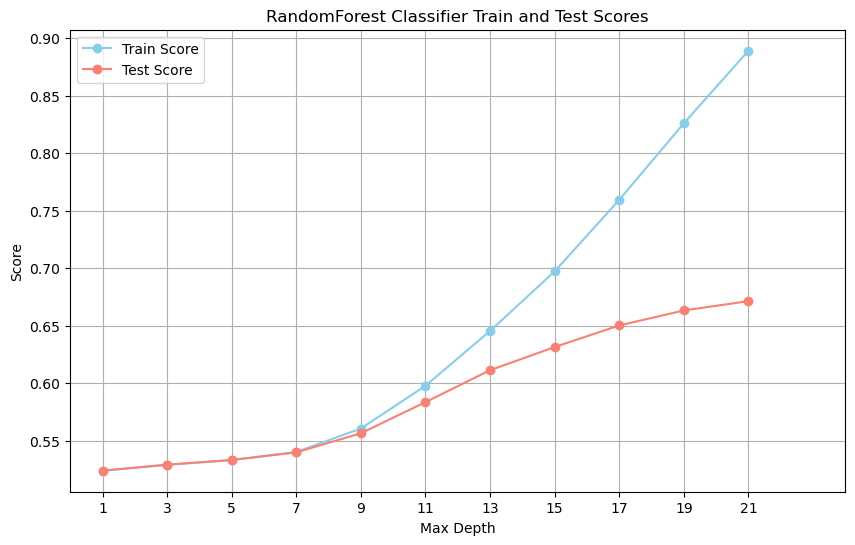

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

scores_df["train"].plot(ax=ax, marker="o", color='skyblue', label="Train Score")
scores_df["test"].plot(ax=ax, marker="o", color='salmon', label="Test Score")

ax.set(
    title="RandomForest Classifier Train and Test Scores",
    xlabel="Max Depth",
    ylabel="Score",
    xticks=depths,
    xlim=(0, 24),
)

ax.grid(True)
ax.legend()
plt.show()

In [26]:
import pickle

# Save model path
model_name = "random_forest_classifier_v2.pkl"
model_path = f"../../../models/{model_name}"

# Save the model to a file
with open(model_path, "wb") as file:
    pickle.dump(clf, file)

print(f"Model saved to {model_path}")

Model saved to ../../../models/random_forest_classifier_v2.pkl


In [27]:
# Predict the target values using the testing data
y_test_predict = clf.predict(X_test_scaled)
y_train_predict = clf.predict(X_train_scaled)

In [28]:
confusion_train, confusion_test = evaluate_classifier_model(
    "Random Forest Classifier",
    y_train,
    y_test,
    y_train_predict,
    y_test_predict
)

╔═══════════════════════════════════════════════════════════════╗
║           Random Forest Classifier Model Evaluation           ║
╠═══════════════════════════════════════════════════════════════╣
║                                |                              ║
║ Training Data Metrics          |                              ║
║ Accuracy (Train):              |           0.61720            ║
║ Precision (Train):             |           0.65253            ║
║ Recall (Train):                |           0.61720            ║
║ F1 Score (Train):              |           0.58176            ║
║                                |                              ║
║ Testing Data Metrics           |                              ║
║ Accuracy (Test):               |           0.59459            ║
║ Precision (Test):              |           0.62033            ║
║ Recall (Test):                 |           0.59459            ║
║ F1 Score (Test):               |           0.55621            ║
╚═════════

In [29]:
import numpy as np

classes = np.unique(y_train)
print("Class order:", classes)

Class order: [0 1]


In [30]:
df_confusion_train = pd.DataFrame(
    confusion_train,
    index=["Actual -1", "Actual 1"],
    columns=["Predicted -1", "Predicted 1"]
)

df_confusion_train

,Predicted -1,Predicted 1
Actual -1,237236,507316
Actual 1,91299,727941


In [31]:
df_confusion_test = pd.DataFrame(
    confusion_test,
    index=["Actual -1", "Actual 1"],
    columns=["Predicted -1", "Predicted 1"]
)

df_confusion_test

,Predicted -1,Predicted 1
Actual -1,54307,131806
Actual 1,26690,178146


In [32]:
cv_scores = cross_val_score(
    clf,
    X_train_scaled,
    y_train,  # Use the original y_train with values 1, -1, and 0
    scoring="accuracy",  # Use accuracy for classification
    cv=5
)

In [33]:
evaluate_cross_validation(cv_scores, "Random Forest Classifier")

╔═══════════════════════════════════════════════════════════════╗
║       Random Forest Classifier Cross Validation Scores        ║
╠═══════════════════════════════════════════════════════════════╣
║ Fold 1:                        |           0.58982            ║
║ Fold 2:                        |           0.59384            ║
║ Fold 3:                        |           0.59306            ║
║ Fold 4:                        |           0.59235            ║
║ Fold 5:                        |           0.59306            ║
║                                |                              ║
║ Mean Score:                    |           0.59242            ║
║ Standard Deviation:            |           0.00139            ║
╚═══════════════════════════════════════════════════════════════╝


### Predict `Adjusted Close`
___
___
___

In [34]:
def preprocess_predict_data(df, columns_to_drop):
    # Convert 'Date' column to datetime
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Extract year, month, and day from 'Date' column
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    
    # Drop specified columns
    df = df.drop(columns=columns_to_drop)
    
    # Set 'Date' and 'Ticker' as the index
    df = df.set_index(["Date", "Ticker"])
    
    df = df.drop(columns="Today to Tomorrow")
    
    return df

In [35]:
# Make a copy of the data we will use to predict
X_to_predict = predict_data.copy()

# Preprocess the data for prediction
X_to_predict = preprocess_predict_data(X_to_predict, select_columns_to_drop)

# Scale the data using the StandardScaler
X_to_predict_scaled = X_scaler.transform(X_to_predict)

print("Shape of predict data:", X_to_predict_scaled.shape)
X_to_predict_scaled

Shape of predict data: (9963, 11)


array([[ 0.30125616,  0.9576267 ,  0.09553659, ...,  1.63650596,
         0.73959997,  1.63126375],
       [ 0.72466876,  0.9576267 ,  0.98511704, ...,  1.63650596,
         0.73959997,  1.63126375],
       [ 0.53940701,  0.9576267 ,  0.58274582, ...,  1.63650596,
         0.73959997,  1.63126375],
       ...,
       [ 0.0719851 , -1.05119446, -0.73485453, ...,  1.63650596,
         1.03322039,  1.05980319],
       [ 1.35956785, -1.05119446, -0.27078565, ...,  1.63650596,
         1.03322039,  1.05980319],
       [ 0.45994846, -1.05119446, -0.39492166, ...,  1.63650596,
         1.03322039,  1.05980319]])

In [36]:
# Predict the target values using the testing data
y_to_predict = clf.predict(X_to_predict_scaled)

print("Shape of y_to_predict:", y_to_predict.shape)
y_to_predict[:5]

Shape of y_to_predict: (9963,)


array([1, 0, 1, 1, 1])

In [37]:
# Create a copy of the predict data so we may add the predictions
prediction_df = predict_data.copy()

# Add the predictions to the predict data made by the model
prediction_df["Pred Today to Tomorrow"] = y_to_predict

# Replace 0 with -1
prediction_df["Pred Today to Tomorrow"] = prediction_df["Pred Today to Tomorrow"].replace(0, -1)

# Make a column "Correct Prediction" to check if the prediction is correct by comparing the actual value and the predicted value
prediction_df["Is Correct Prediction"] = prediction_df["Today to Tomorrow"] == prediction_df["Pred Today to Tomorrow"]

# Select the columns to keep
prediction_df = prediction_df[
    [
        'Date',
        'Ticker',
        'Adjusted Close',
        'Today to Tomorrow',
        'Pred Today to Tomorrow',
        'Is Correct Prediction'
    ]
]

# Drop rows with missing values
prediction_df.dropna(inplace=True)

# Set the index to 'Date' and 'Ticker' to better group the data
prediction_df = prediction_df.set_index(["Date", "Ticker"])

print("Shape:", prediction_df.shape)
display(prediction_df.head())
display(prediction_df.tail())

Shape: (9462, 4)


Adjusted Close  Today to Tomorrow  Pred Today to Tomorrow  \
Date       Ticker                                                              
2024-09-30 A           148.244000               -1.0                       1   
           AAPL        233.000000               -1.0                      -1   
           ABBV        195.915500               -1.0                       1   
           ABNB        126.810000               -1.0                       1   
           ABT         113.475204               -1.0                       1   

                   Is Correct Prediction  
Date       Ticker                         
2024-09-30 A                       False  
           AAPL                     True  
           ABBV                    False  
           ABNB                    False  
           ABT                     False

Adjusted Close  Today to Tomorrow  Pred Today to Tomorrow  \
Date       Ticker                                                              
2024-10-24 XYL             130.65               -1.0                       1   
           YUM             133.16               -1.0                       1   
           ZBH             104.00               -1.0                       1   
           ZBRA            362.05               -1.0                       1   
           ZTS             181.50               -1.0                       1   

                   Is Correct Prediction  
Date       Ticker                         
2024-10-24 XYL                     False  
           YUM                     False  
           ZBH                     False  
           ZBRA                    False  
           ZTS                     False

In [38]:
prediction_df["Is Correct Prediction"].value_counts()

Is Correct Prediction
True     4923
False    4539
Name: count, dtype: int64

In [39]:
# Inspect Cleaned data zeroing in on individual tickers
select_df = prediction_df.copy().reset_index()

select_ticker = select_df["Ticker"] == "AAPL"

display(select_df[select_ticker].set_index(["Date", "Ticker"])["Is Correct Prediction"].value_counts())
select_df[select_ticker].set_index(["Date", "Ticker"]).tail()

Is Correct Prediction
True     10
False     9
Name: count, dtype: int64

,,Adjusted Close,Today to Tomorrow,Pred Today to Tomorrow,Is Correct Prediction
Date,Ticker,,,,
2024-10-18,AAPL,235.00,1.0,1,True
2024-10-21,AAPL,236.48,-1.0,1,False
2024-10-22,AAPL,235.86,-1.0,1,False
2024-10-23,AAPL,230.76,-1.0,1,False
2024-10-24,AAPL,230.57,1.0,1,True


In [40]:
# Make index column a regular column
prediction_df.reset_index(inplace=True)

prediction_df

,Date,Ticker,Adjusted Close,Today to Tomorrow,Pred Today to Tomorrow,Is Correct Prediction
0,2024-09-30,A,148.244000,-1.0,1,False
1,2024-09-30,AAPL,233.000000,-1.0,-1,True
2,2024-09-30,ABBV,195.915500,-1.0,1,False
3,2024-09-30,ABNB,126.810000,-1.0,1,False
4,2024-09-30,ABT,113.475204,-1.0,1,False
...,...,...,...,...,...,...
9457,2024-10-24,XYL,130.650000,-1.0,1,False
9458,2024-10-24,YUM,133.160000,-1.0,1,False
9459,2024-10-24,ZBH,104.000000,-1.0,1,False
9460,2024-10-24,ZBRA,362.050000,-1.0,1,False


In [ ]:
file_name = "clf_random_forest_predictions_v2"
file_path = f"../../../data/raw_data/{file_name}"

save_data(prediction_df, file_path)